In [1]:
#https://medium.com/@koki_noda/ultimate-guide-to-graph-neural-networks-2-texas-dataset-f70782190f80
import os
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sp
import torch
from torch import nn
from torch import Tensor
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import WebKB
import networkx as nx
from networkx.algorithms import community

data_dir = './data'
os.makedirs(data_dir,exist_ok = True)

In [2]:
dataset = WebKB(root= data_dir, name ='texas')
data= dataset[0]

In [10]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')

Number of nodes: 183
Number of edges: 325


In [3]:
n_self_loop = 0
for i in range(data.num_edges):
    if data.edge_index[0,i] == data.edge_index[1,i]:
        n_self_loop += 1
print(n_self_loop)

16


In [4]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self_loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Has isolated nodes: False
Has self_loops: True
Is undirected: False


In [5]:
edge_index = data.edge_index.numpy()
print(edge_index.shape)

(2, 325)


In [6]:
index = 15
edge_example_outward = edge_index[:,np.where(edge_index[0]==index)[0]]
edge_example_intward = edge_index[:,np.where(edge_index[1]==index)[0]]
edge_example_outward

array([[ 15,  15,  15,  15,  15],
       [ 15,  16,  22,  65, 165]])

In [7]:
list(zip(edge_example_intward[0],edge_example_intward[1]))

[(15, 15), (20, 15), (57, 15), (92, 15), (174, 15)]

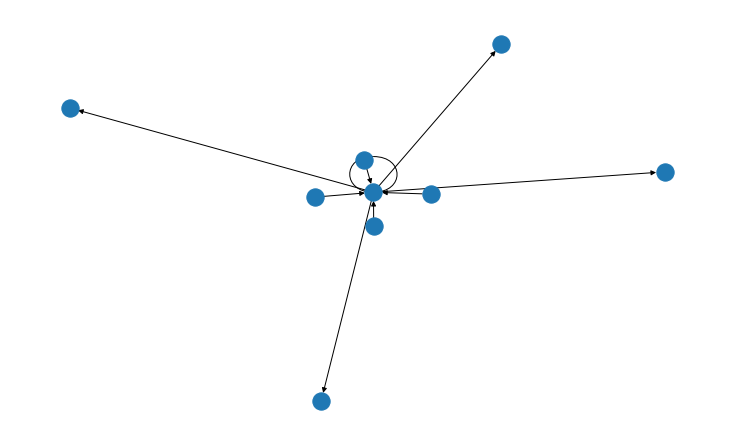

In [8]:
node_example = np.unique(np.concatenate([edge_example_outward.flatten(),edge_example_intward.flatten()]))

plt.figure(figsize=(10,6))
G = nx.DiGraph()
G.add_nodes_from(node_example)
G.add_edges_from(list(zip(edge_example_outward[0],edge_example_outward[1])))
G.add_edges_from(list(zip(edge_example_intward[0],edge_example_intward[1])))
nx.draw(G,with_labels = False)

In [9]:
print(f'Average node degree: {data.num_edges/data.num_nodes:.2f}')

Average node degree: 1.78


,count,mean,std,min,25%,50%,75%,max
0,183.0,3.55,7.93,1.0,1.0,2.0,4.0,104.0


183
650


Text(0.5, 0, 'node degree')

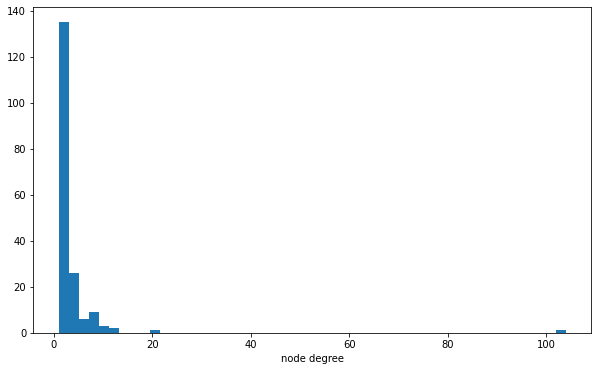

In [10]:
G = to_networkx(data, to_undirected=False)
degrees = [val for (node,val) in G.degree()]
display(pd.DataFrame(pd.Series(degrees).describe()).transpose().round(2))
print(len(degrees))
print(sum(degrees))
plt.figure(figsize=(10,6))
plt.hist(degrees, bins= 50)
plt.xlabel('node degree')

threshold 0.049450549450549455


/Users/maryamkia/Homebrew/Caskroom/miniforge/base/envs/pytorch_x86/lib/python3.8/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


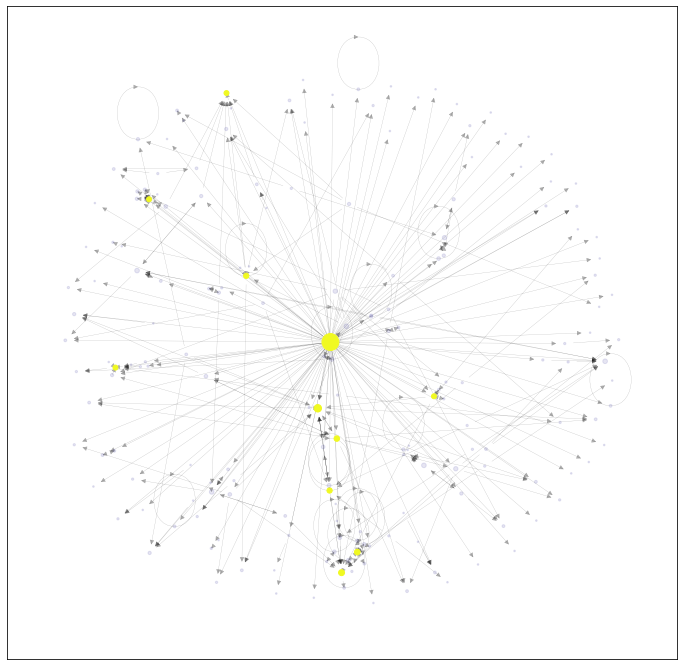

In [11]:
G = to_networkx(data, to_undirected=False)
pos = nx.spring_layout(G, seed = 42)
cent = nx.degree_centrality(G)
node_size= list(map(lambda x:x*500,cent.values()))

cent_array = np.array(list(cent.values()))
threshold = sorted(cent_array, reverse= True)[10]
print('threshold', threshold)
cent_bin = np.where(cent_array>=threshold,1,0.1)
plt.figure(figsize=(12,12))

nodes = nx.draw_networkx_nodes(G, pos, node_size= node_size,
                                cmap= plt.cm.plasma,
                                node_color=cent_bin, 
                                nodelist=list(cent.keys()),
                                alpha=cent_bin)
edges = nx.draw_networkx_edges(G, pos, width= 0.25, alpha= 0.3)

In [13]:
print(f'Number of features: {data.num_node_features} ')

Number of features: 1703 


In [14]:
print(len(data.x[0]))
data.x[1][:20]

1703


tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
        0., 0.])

In [15]:
print(f'Number of class: {dataset.num_classes}')

Number of class: 5


In [17]:
label_dict = {
                0:'student',
                1:'project',
                2:'course',
                3:'staff',
                4:'faculty'
                }
data.y[:10]

tensor([3, 0, 2, 3, 4, 3, 0, 0, 3, 0])

{3: 101, 0: 33, 2: 18, 4: 30, 1: 1}


Text(0.5, 0, 'class')

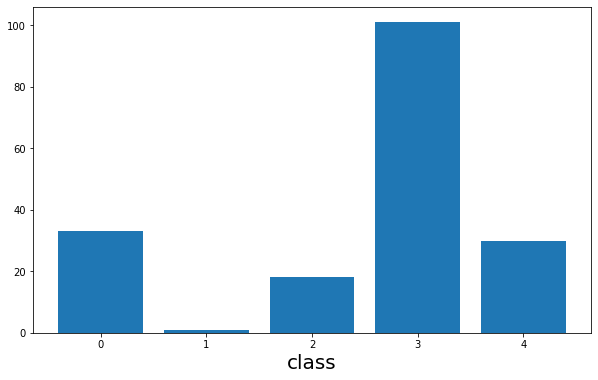

In [18]:
counter = collections.Counter(data.y.numpy())
counter = dict(counter)
print(counter)
count = [x[1] for x in sorted(counter.items())]

plt.figure(figsize=(10,6))
plt.bar(range(5), count)
plt.xlabel('class', size=20)

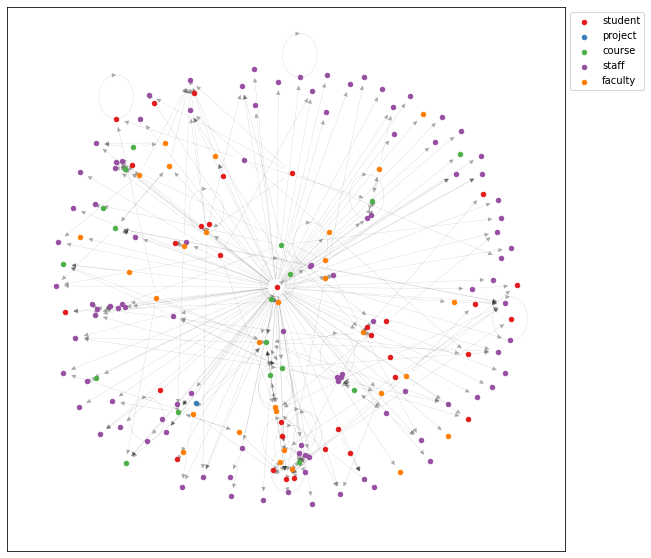

In [20]:
G = to_networkx(data,to_undirected=False)
node_color = []
nodelist = [[],[],[],[],[]]
colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
labels = data.y
for n,i in enumerate(labels):
    node_color.append(nodelist[i])
    nodelist[i].append(n)
pos = nx.spring_layout(G,seed = 42)
plt.figure(figsize=(10,10))
labellist= list(label_dict.values())

for num, i in enumerate(zip(nodelist,labellist)):
    n,l = i[0],i[1]
    nx.draw_networkx_nodes(G, pos,nodelist = n,
                            node_size= 20,
                            node_color = colorlist[num],
                            label = l)

nx.draw_networkx_edges(G,pos,width= 0.2,alpha = 0.3)
plt.legend(bbox_to_anchor= (1,1),loc='upper left')
#plt.savefig('texas.png',dpi = 150, bbox_inches='tight')


label: 0
138 edges
{4: 30, 3: 94, 0: 3, 2: 11}
label: 1
2 edges
{2: 2}
label: 2
58 edges
{3: 39, 4: 12, 2: 6, 0: 1}
label: 3
54 edges
{2: 26, 0: 7, 3: 20, 4: 1}
label: 4
73 edges
{0: 24, 3: 25, 4: 6, 2: 18}


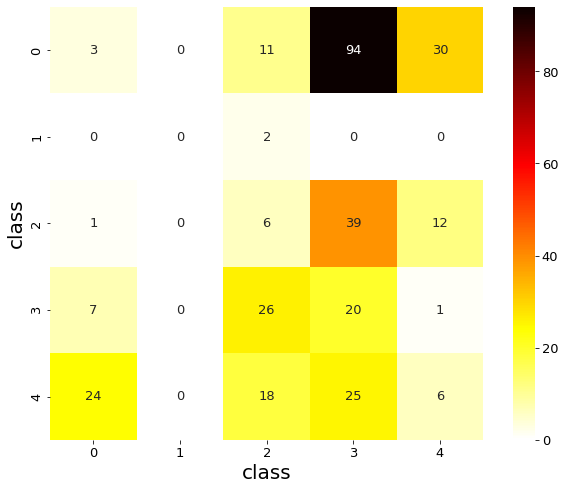

In [21]:
labels = data.y.numpy()
connected_labels_set = list(map(lambda x: labels[x], data.edge_index.numpy()))
connected_labels_set = np.array(connected_labels_set)
def add_missing_keys(counter, classes):
    for x in classes:
        if x not in counter.keys():
            counter[x] = 0
    return counter
label_connection_counts = []
for i in range(5):
    print(f"label: {i}")
    connected_labels = connected_labels_set[:, np.where(connected_labels_set[0] == i)[0]]
    print(connected_labels.shape[1], "edges")
    counter = collections.Counter(connected_labels[1])
    counter = dict(counter)
    print(counter)
    counter = add_missing_keys(counter, range(5))
    items = sorted(counter.items())
    items = [x[1] for x in items]
    label_connection_counts.append(items)
label_connection_counts = np.array(label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(label_connection_counts, annot=True, cmap='hot_r', cbar=True, square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

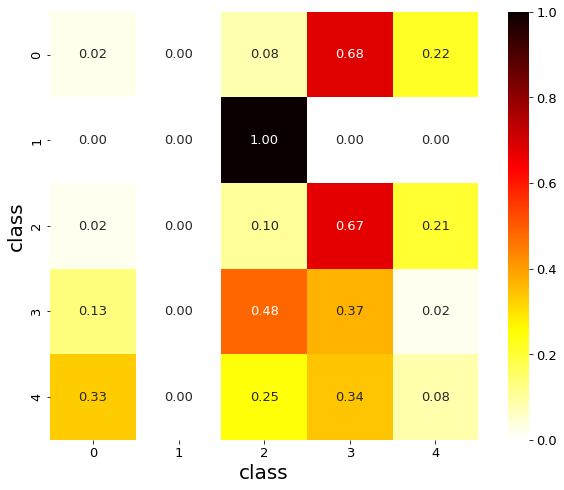

In [24]:
def scaling(array):
    return array / sum(array)
label_connection_counts_scaled = np.apply_along_axis(scaling, 1, label_connection_counts)
plt.figure(figsize=(9, 7))
plt.rcParams["font.size"] = 13
hm = sns.heatmap(
    label_connection_counts_scaled,
    annot=True,
    cmap='hot_r',
    fmt="1.2f",
    cbar=True,
    square=True)
plt.xlabel("class",size=20)
plt.ylabel("class",size=20)
plt.tight_layout()
plt.show()

In [25]:
print(f'Number of training nodes: {data.train_mask[:, 0].sum()}')
print(f'Number of validation nodes: {data.val_mask[:, 0].sum()}')
print(f'Number of test nodes: {data.test_mask[:, 0].sum()}')

Number of training nodes: 87
Number of validation nodes: 59
Number of test nodes: 37


Training {3: 46, 2: 7, 4: 20, 0: 14, 1: 0}
Validation {0: 15, 3: 31, 1: 1, 4: 5, 2: 7}
Test {3: 24, 0: 4, 2: 4, 4: 5, 1: 0}


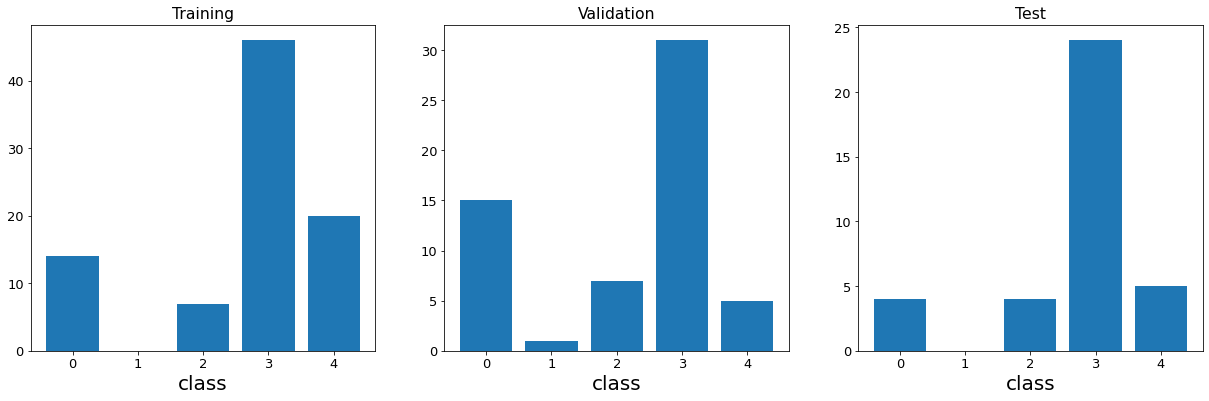

In [28]:
split_version = 0  # 0 to 9
split_type_array = np.zeros(data.num_nodes)
split_type_array[np.where(data.train_mask[:, split_version] == True)[0]] = 1
split_type_array[np.where(data.val_mask[:, split_version] == True)[0]] = 2
split_type_array[np.where(data.test_mask[:, split_version] == True)[0]] = 3
split_type_array
titles = ["Training", "Validation", "Test"]
fig, axes = plt.subplots(ncols=3, figsize=(21, 6))
for i in range(3):
    counter = collections.Counter(data.y.numpy()[np.where(split_type_array == i + 1)[0]])
    counter = dict(counter)
    counter = add_missing_keys(counter, range(dataset.num_classes))
    print(titles[i], counter)
    count = [x[1] for x in sorted(counter.items())]
    axes[i].bar(range(dataset.num_classes), count)
    axes[i].set_xlabel("class", size=20)
    axes[i].set_title(titles[i])
plt.show()